# Events

Events are sudden changes to counts in the simulation happening at specific times or due to the fulfilement of certain conditions. In this example we set the count of the meta-species A to 200 at every 5 seconds.

Compiling model



Species
A,200

Mappings
A :
A

Parameters
volume,1

Reactions
reaction_0,{'re': [(1, 'A')], 'pr': [], 'kin': 'A * 1'}

Events
event_0,{'trigger': 'true', 'delay': '10', 'assignments': [('A', '200')]}
event_1,{'trigger': 'true', 'delay': '5', 'assignments': [('A', '200')]}



Starting Simulator
Running simulation in parallel
Simulation is Over


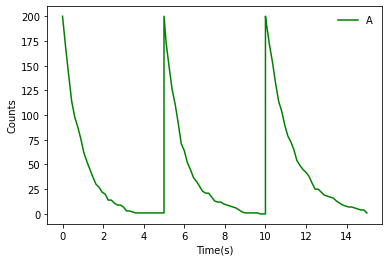

In [1]:
from mobspy import *

A = BaseSpecies()

A >> Zero [1]

A(200)
S = Simulation(A)
S.method = 'stochastic'
S.duration = 15
S.output_event = True

with S.event_time(5):
    A(200)

with S.event_time(10):
    set_counts({A: 200})

print(S.compile())
S.run()

As one can see, one can assign counts to events by putting the simulation under context. 
Once the simulation is under context every count assign to a meta-species will be assigned as an event. 
The count assignment is equal to the one presented in the Initial Conditions with both the queries and All operator working in similar maner. The set_count operator is also accepted for events. 

Besides timed events, one has access to conditional events. Conditional events trigger once a specific logic expression has been satisfied. In the following model, we desing two meta-species, A and B with two characteristics each and we set their counts to 200 if they both go bellow 50. 

Compiling model



Species
A.a1,100
A.a2,100
B.b1,120
B.b2,120

Mappings
A :
A.a1
A.a2
B :
B.b1
B.b2

Parameters
volume,1

Reactions
reaction_0,{'re': [(1, 'A.a1'), (1, 'B.b1')], 'pr': [], 'kin': 'A.a1 * B.b1 * 0.01 * volume^-1'}
reaction_1,{'re': [(1, 'A.a2'), (1, 'B.b2')], 'pr': [], 'kin': 'A.a2 * B.b2 * 0.02 * volume^-1'}

Events
event_0,{'trigger': '( ( (A.a1 + A.a2) <= 50 ) && ( (B.b1 + B.b2) <= 50 ) ) ', 'delay': '0', 'assignments': [('A.a1', '100'), ('A.a2', '100'), ('B.b1', '120'), ('B.b2', '120')]}



Starting Simulator
Running simulation in parallel
Simulation is Over


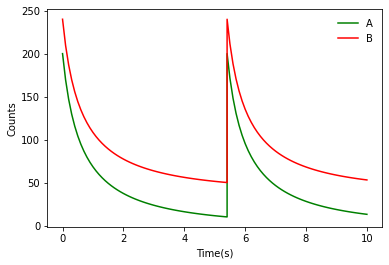

In [2]:
A, B = BaseSpecies()

A.a1, A.a2, B.b1, B.b2

A.a1 + B.b1 >> Zero [0.01]
A.a2 + B.b2 >> Zero [0.02]

All[A](100), All[B](120)
S = Simulation(A | B)
S.duration = 10
S.output_event = True

logic_expression = (A <= 50) & (B <= 50)
with S.event_condition(logic_expression):
    All[A](100), All[B](120)

print(S.compile())
S.run()

Like in the results, MobsPy automatically maps A = A.a1 + A.a2 and B = B.b1 + B.b2. Once the counts of the species in all states go bellow the defined thresholds the event trigger and set the counts back up. 

Logical clauses in MobsPy must be isolated in parenthesis when combined to respect Python operator precedence other. As if the parenthesis where not there, Python would try to resolve the operator '&' (and) before the inequalities. The operator '|' symbolises or and the operator '&' simbolises and. Finally, the equality operator is not allowed as it can create compatibility issues with python. In the code bellow, there are some examples of MobsPy logical clauses.

In [3]:
# Perform a query 
c1 = A.a1 <= 10 
# Combine clauses
c2 = ((A.a1 <= 10) | (B >= 5)) & (A.a2 >= 5)

# EQUALITY IS NOT ALLOWED AND WILL PRODUCE ERRORS 
# The alternative is them 
c3 = (A <= 5) & (A >= 5)

Another aspect is to create simulations with a conditional duration by passing a logical clause. For instance, the simulation bellow runs until either A or B reach zero.

In [4]:
A, B = BaseSpecies()

A + B >> Zero [0.01]

A(110), B(100)
S = Simulation(A | B)
S.method = 'stochastic'
S.duration = (A <= 0) | (B <= 0)
S.run()

Compiling model
Starting Simulator
Running simulation in parallel
Simulation is Over
ERROR: At:             copier = getattr(x, "__deepcopy__", None) 
Line number: 151 
Characteristic name __deepcopy__ is not allowed. Please pick another name


SystemExit: 1

/Users/fabriciocravo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


As a important note, reactions CANNOT be added as events.

If one wishes to desing event assignments based around the value of meta-species, one can pass strings in the count assignment under an event context. For instance, the model bellow uses the meta-species I to count the number of times A reaches zero in an windown of time:

In [ ]:
A, I = BaseSpecies()

A >> Zero [1]

A(10), I(0)
S = Simulation(A | I)
S.method = 'stochastic'
S.duration = 15
S.step_size = 0.01

with S.event_condition(A <= 0):
    A(10), I(f'{I} + 1')

print(S.compile())
S.run()

Again queries can be performed inside the string assignment. If a meta-species is used under this type of assignment the resulting string will be the sum of all the states.

In [ ]:
A = BaseSpecies()

A.a1, A.a2, A.a3

S = Simulation(A)

A(0)
with S.event_time(5):
    All[A](f'{A} + 1')
    
print(S.compile())